In [1]:
from itertools import accumulate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

df_revlogs = pd.read_parquet("./data/revlogs")
df_cards = pd.read_parquet("./data/cards")
df_decks = pd.read_parquet("./data/decks")
df_joined = df_revlogs.merge(df_cards, on="card_id", how="left").merge(
    df_decks, on="deck_id", how="left"
)
print(f"total rows: {len(df_joined)}")
df_joined["review_th"] = range(1, len(df_joined) + 1)
df_joined.sort_values(by=["card_id", "review_th"], inplace=True)


def cum_concat(x):
    return list(accumulate(x))


t_history_list = df_joined.groupby("card_id", group_keys=False)[
    "elapsed_seconds"
].apply(lambda x: cum_concat([[max(0, i)] for i in x]))
r_history_list = df_joined.groupby("card_id", group_keys=False)["rating"].apply(
    lambda x: cum_concat([[i] for i in x])
)
df_joined["r_history"] = [
    ",".join(map(str, item[:-1])) for sublist in r_history_list for item in sublist
]
df_joined["t_history"] = [
    ",".join(map(str, item[:-1])) for sublist in t_history_list for item in sublist
]
df_joined["y"] = df_joined["rating"].map(lambda x: 1 if x > 1 else 0)
df_joined.groupby("preset_id").size()

total rows: 1344154


preset_id
0      33121
1       2078
2      29829
3       6738
4      10223
5      18425
6       9682
7      11648
8     259460
9     159355
10     71061
11     83998
12      2398
13      2796
14      1361
15      9443
16     73158
17    132062
18    181740
19       959
20     29726
21     54765
22     30371
23     35260
24      1920
25     48056
26      1806
27     38415
28      3242
29      1058
dtype: int64

In [2]:
DECAY = -0.5


def power_forgetting_curve(t, s, decay=DECAY):
    factor = 0.9 ** (1 / decay) - 1
    return (1 + factor * t / s) ** decay


def fit_stability(delta_t, retention, size, decay=DECAY):

    def loss(stability):
        y_pred = power_forgetting_curve(delta_t, stability, decay).clip(
            1e-10, 1 - 1e-10
        )
        loss = sum(
            -(retention * np.log(y_pred) + (1 - retention) * np.log(1 - y_pred)) * size
        )
        return loss

    res = minimize(loss, x0=1, bounds=[(0.1, None)])
    return res.x[0]


def format_time(x, pos=None):
    if x < 60:
        return f"{x:.0f}s"
    elif x < 3600:
        return f"{x/60:.2f}m"
    elif x < 86400:
        return f"{x/3600:.2f}h"
    else:
        return f"{x/86400:.2f}d"


def filter_data(data):
    Q1 = data["elapsed_seconds"].quantile(0.25)
    Q3 = data["elapsed_seconds"].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data = data[
        (data["elapsed_seconds"] >= lower_bound)
        & (data["elapsed_seconds"] <= upper_bound)
    ]
    return data


r_history_list = ["1", "1,3", "1,3,3", "1,3,3,3", "1,3,3,3,3", "1,3,3,3,3,3"]
# r_history_list = ["3", "3,3", "3,3,3", "3,3,3,3", "3,3,3,3,3", "3,3,3,3,3,3"]
r_history_delta_t_bounds = {}
N = 5  # Can be adjusted to any number

df = df_joined[
    (df_joined["r_history"].isin(r_history_list)) & (df_joined["preset_id"] == 11)
]
df = (
    df.groupby("r_history", as_index=True)
    .apply(filter_data, include_groups=False)
    .reset_index(level="r_history")
)

(3764, 15)


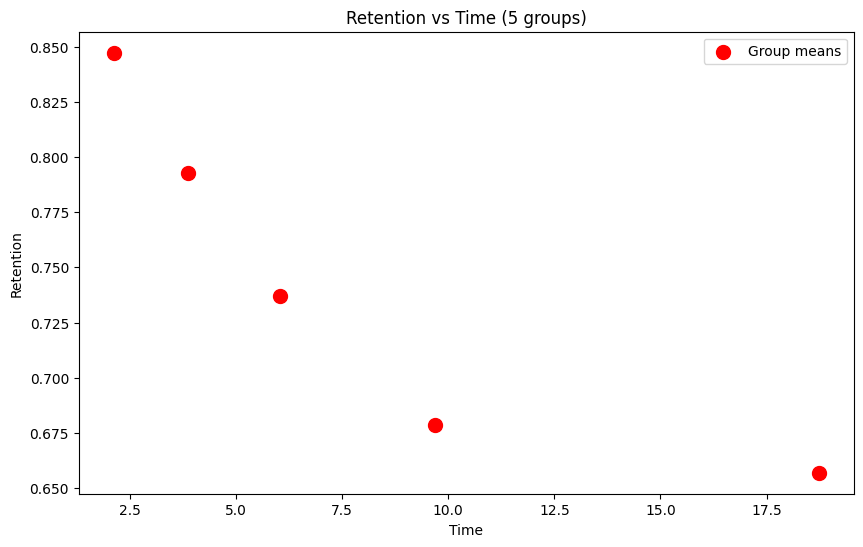

In [3]:
# Split into groups and assign group numbers
n_splits = 5
data_subset = df[df["r_history"] == "1"].sort_values(by="elapsed_seconds").copy()
print(data_subset.shape)
split_indices = np.array_split(np.arange(len(data_subset)), n_splits)

# Add group column
data_subset["group"] = -1
for i, indices in enumerate(split_indices):
    data_subset.iloc[indices, data_subset.columns.get_loc("group")] = i

# Update original dataframe
df.loc[data_subset.index, "group"] = data_subset["group"]

# Rest of the plotting code remains the same
means = []
for i in range(n_splits):
    group_data = data_subset[data_subset["group"] == i]
    x_mean = group_data["elapsed_seconds"].mean()
    y_mean = group_data["y"].mean()
    means.append((x_mean, y_mean))

# Convert to numpy array for easier plotting
means = np.array(means)

# Plot the means
plt.figure(figsize=(10, 6))
plt.scatter(means[:, 0], means[:, 1], color="red", s=100, label="Group means")
plt.xlabel("Time")
plt.ylabel("Retention")
plt.legend()
plt.title("Retention vs Time (5 groups)")
plt.show()

(411, 16)


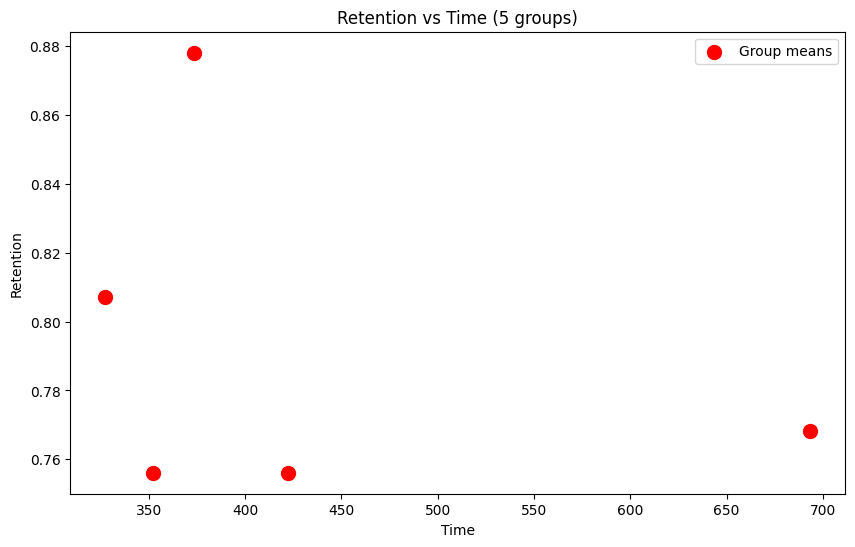

In [4]:
# Split into groups and assign group numbers
n_splits = 5
data_subset = (
    df[
        (df["r_history"] == "1,3")
        & (df["card_id"].isin(df[df["group"] == 3]["card_id"]))
    ]
    .sort_values(by="elapsed_seconds")
    .copy()
)
print(data_subset.shape)
split_indices = np.array_split(np.arange(len(data_subset)), n_splits)

# Add group column
data_subset["group"] = -1
for i, indices in enumerate(split_indices):
    data_subset.iloc[indices, data_subset.columns.get_loc("group")] = i

# Update original dataframe
df.loc[data_subset.index, "group"] = data_subset["group"]

# Rest of the plotting code remains the same
means = []
for i in range(n_splits):
    group_data = data_subset[data_subset["group"] == i]
    x_mean = group_data["elapsed_seconds"].mean()
    y_mean = group_data["y"].mean()
    means.append((x_mean, y_mean))

# Convert to numpy array for easier plotting
means = np.array(means)

# Plot the means
plt.figure(figsize=(10, 6))
plt.scatter(means[:, 0], means[:, 1], color="red", s=100, label="Group means")
plt.xlabel("Time")
plt.ylabel("Retention")
plt.legend()
plt.title("Retention vs Time (5 groups)")
plt.show()